In [1]:
#Load packages
from netCDF4 import Dataset
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import sys
import netCDF4 as nc4
from torch import nn
from torch import optim
import progressbar
import pytorch_lightning as pl
import torch.nn.functional as F
from torchvision import transforms
from torch import nn
from torch import optim
import progressbar
sys.path.append("/home2/datahome/tpicard/python/Python_Modules_p3_pyticles/")
sys.path.append("/home2/datahome/tpicard/PhD_MOMOPAR/TRAIN_AND_VALIDATION_CNN/OLD")
import torch
from torch.utils.data import DataLoader, Dataset
from CNN_tools import *
from CNN_UNET import *
from pytorch_lightning.callbacks import ModelCheckpoint
from DATALOADER import Pdf_Image_DataSet
from variables import *
import importlib
from Modules import *
from Modules_gula import *
from plot_function import *

# Function that take all the particules positions px and py 
# (pxcenter,pycenter) is the center of a sub-patch that containt 36 particles 
# index_start is generally 0, 20 or 40 and correspond to the number of time step after the starting period of simu
# Return a list of index that correspond to the particles located inside the sub-patch

def spatial_filter(px,py,pxcenter,pycenter,index_start):
    
    #On garde que le premier pas de temps
    px = px[0,0:10201]
    py = py[0,0:10201]
    
    a = np.where(abs(px - pxcenter) <= 3,1,0) # Filter on lon
    b = np.where(abs(py - pycenter) <= 3,1,0) # Filter on lat
    c = np.multiply(a,b) 
    index = np.argwhere(c == 1) # Combinason of both filter
    #print(index.shape)
    index_tot = []
    
    for i in range(index_start,index_start+20): # We consider all the particles released for a 10 days perdiod
        index_temp = index + 10201*(i)
        index_tot.append(index_temp)
        
    return np.array(index_tot).ravel()

# # Compute ouputs
[ic,jc] = np.load('/home2/datahome/tpicard/Pyticles/Inputs/ic_jc.npy')

def compute_variable(tstart,ic,jc):
    
    my_simul = 'apero'
    my_simul = 'aperitif_simu2'

    #parameters = my_simul + ' [1068,2068,117,1117,[1,100,1]] '+ format(date_plot_AC)
    str_para = ' [{0},{1},{2},{3},[1,100,1]] '.format(jc-260,jc+260,ic-260,ic+260)
    parameters = my_simul +str_para+ format(tstart)
    simul = load(simul = parameters, floattype=np.float64)
    print(simul.date)

    depth = [0,-200,-500,-1000]
    temp = var('temp',simul,depths=depth).data
    ssh = var('zeta',simul).data
    u = var('u',simul,depths=depth).data
    v = var('v',simul,depths=depth).data


    
    vrt = np.zeros(temp.shape)
    for i in range(len(depth)):
        vrt[:,:,i] =  tools.psi2rho(tools.get_vrt(u[:,:,i],v[:,:,i],simul.pm,simul.pn) / tools.rho2psi(simul.f))
        #vrt[:,:,i] =  (tools.get_vrt(u[:,:,i],v[:,:,i],simul.pm,simul.pn) / (simul.f))
    
    u = tools.u2rho(u)
    v = tools.v2rho(v)
    
    topo = simul.topo
    ##############################################################
    # Define horizontal coordinates (deg, km, or grid points)
    ########################################################

    #coord = 'points'
    coord = 'km'

    if coord=='deg':
        #using lon,lat
        lon = simul.x; lat = simul.y
        xlabel = 'lon'; ylabel = 'lat'
    elif coord=='km':
        # using km
        [lon,lat] = np.meshgrid(np.arange(simul.x.shape[0])+simul.coord[2],np.arange(simul.x.shape[1])+simul.coord[0])
        lon = (lon/np.mean(simul.pm)*1e-3).T
        lat = (lat/np.mean(simul.pn)*1e-3).T
        xlabel = 'km'; ylabel = 'km'
    elif coord=='points':
        # using grid points
        [lon,lat] = np.meshgrid(np.arange(simul.x.shape[0])+simul.coord[2],np.arange(simul.x.shape[1])+simul.coord[0])
        lon,lat = lon.T,lat.T
        xlabel = 'grid pts'; ylabel = 'grid pts'
        
    lon = lon - lon[int(lon.shape[0]/2),0]
    lat = lat - lat[0,int(lat.shape[1]/2)]
    
    return (vrt,temp,ssh,u,v,lon,lat,topo)

# LIST OF ST POSITIONS 
ic_all_list = np.linspace(1520.5,1610.5,6) #LONGITUDE
jc_all_list = np.linspace(569.5,659.5,6) #LAT

# LOAD SIMULATION DATA 

In [2]:
[ic_ori,jc_ori] = np.load('/home2/datahome/tpicard/Pyticles/Inputs/ic_jc.npy')
tstart = 2020-40 # Milieu de l'experience
(vrt,temp,ssh,u,v,lon,lat,topo) = compute_variable(tstart,ic_ori,jc_ori)

simulname is None
args (['aperitif_simu2', '[357,877,1308,1828,[1,100,1]]', '1980'],)
args[0] ['aperitif_simu2', '[357,877,1308,1828,[1,100,1]]', '1980']
len(args[0]) 3
time of simulation is: 1980
coord
loading /home/datawork-lops-osi/mlecorre/POLGYR/INIT/polgyr_grd.nc
loading /home/datawork-lops-osi/mlecorre/POLGYR/HIS_02012020/polgyr_his.01980.nc
get domain [357,877,1308,1828,[1,100,1]] [357,
coordmax
loading /home/datawork-lops-osi/mlecorre/POLGYR/INIT/polgyr_grd.nc
loading /home/datawork-lops-osi/mlecorre/POLGYR/HIS_02012020/polgyr_his.01980.nc
get domain [0,1e9,0,1e9,[1,1e9,1]] [0,1e
cst
read Cs_r in ncfile.Cs_r
dt
dt is read in  /home/datawork-lops-osi/mlecorre/POLGYR/HIS_02012020/polgyr_his.01980.nc
Sep 02 - 00:00


# PLOT ST POSITIONS

<ipython-input-3-1eace09874dd>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lon,lat,vrt[:,:,3],cmap = plt.cm.RdBu_r,vmax=0.5,vmin=-0.5)


Text(-450, 450, 'z = 1000 m')

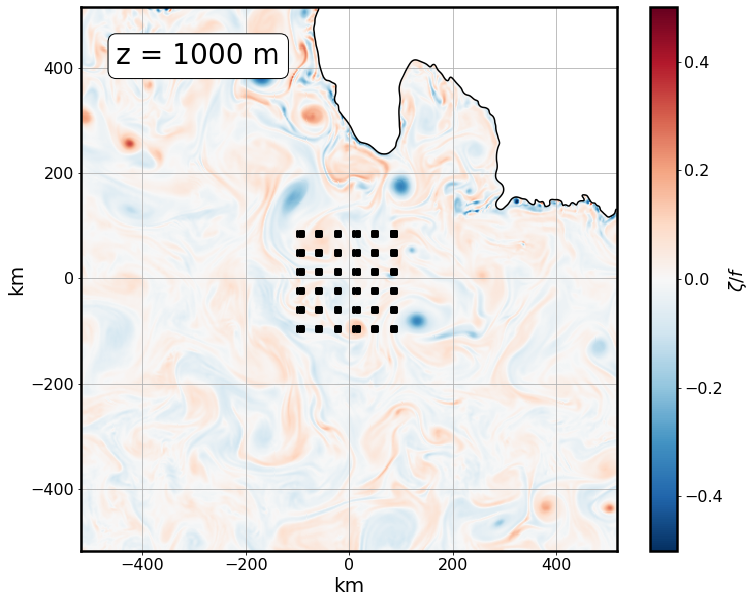

In [3]:
folder = '/home2/datawork/tpicard/Pyticles/OUTPUTS/7YEARS/'
file = folder + 'apero_trap1000m_sed50_2000dx_100nx_000505_56_0500.nc'


#List of the 36 sub-patches centers 
ic_all_list = np.linspace(1520.5,1610.5,6) #LONGITUDE
jc_all_list = np.linspace(569.5,659.5,6) #LAT
#Load data

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

nc_data = nc4.Dataset(file, 'r')
px = np.asfortranarray(nc_data.variables['px'])
py = np.asfortranarray(nc_data.variables['py'])
pdepth = np.asfortranarray(nc_data.variables['pdepth'])
nc_data.close()

plt.figure(figsize=(12,10))

plt.pcolormesh(lon,lat,vrt[:,:,3],cmap = plt.cm.RdBu_r,vmax=0.5,vmin=-0.5)
cb = plt.colorbar()
plt.contour(lon,lat,topo,[1000],colors='k')
cb.set_label(r'$\zeta/f$',fontsize=18)
cb.ax.tick_params(labelsize=16)
#plt.scatter(px[0,0:10201],py[0,0:10201])
plt.xticks(size=16)
plt.yticks(size=16)
plt.ylabel('km',size=20)
plt.xlabel('km',size=20)
plt.grid()

for ic in ic_all_list[:]:
    for jc in jc_all_list:
        index = spatial_filter(px,py,ic,jc,0)
        px_km = (px[0,index]-ic_ori)*2
        py_km = (py[0,index]-jc_ori)*2
        #plt.scatter(px[0,index],py[0,index])
        plt.scatter(px_km,py_km,s=3,color='k')
        
plt.scatter(px_km,py_km,s=3,color='k',label = 'Patch of particles')

props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
textstr = 'z = 1000 m'
plt.text(-450, 450, textstr, fontsize=28,
        verticalalignment='top', bbox=props)

#plt.title("Period : 6000 - 6060")
#plt.savefig('particle_patches.png',dpi=400)

# EXAMPLES OF CATCHMENT AREAS 

In [4]:
date_start = 2020
jpdf = jpdf_no_centering(date_start)
[ic_ori,jc_ori] = np.load('/home2/datahome/tpicard/Pyticles/Inputs/ic_jc.npy')
tstart = date_start+100-40
(vrt,temp,ssh,u,v,lon,lat,topo) = compute_variable(tstart,ic_ori,jc_ori)

(9, 36, 3, 100, 100)
simulname is None
args (['aperitif_simu2', '[357,877,1308,1828,[1,100,1]]', '2080'],)
args[0] ['aperitif_simu2', '[357,877,1308,1828,[1,100,1]]', '2080']
len(args[0]) 3
time of simulation is: 2080
coord
loading /home/datawork-lops-osi/mlecorre/POLGYR/INIT/polgyr_grd.nc
loading /home/datawork-lops-osi/mlecorre/POLGYR/HIS_02012020/polgyr_his.02080.nc
get domain [357,877,1308,1828,[1,100,1]] [357,
coordmax
loading /home/datawork-lops-osi/mlecorre/POLGYR/INIT/polgyr_grd.nc
loading /home/datawork-lops-osi/mlecorre/POLGYR/HIS_02012020/polgyr_his.02080.nc
get domain [0,1e9,0,1e9,[1,1e9,1]] [0,1e
cst
read Cs_r in ncfile.Cs_r
dt
dt is read in  /home/datawork-lops-osi/mlecorre/POLGYR/HIS_02012020/polgyr_his.02080.nc
Oct 22 - 00:00


<ipython-input-5-d7c8b8f40a7e>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lon,lat,vrt[:,:,1],cmap = plt.cm.RdBu_r,vmax=0.5,vmin=-0.5)


Text(-450, 450, 'z = 200 m')

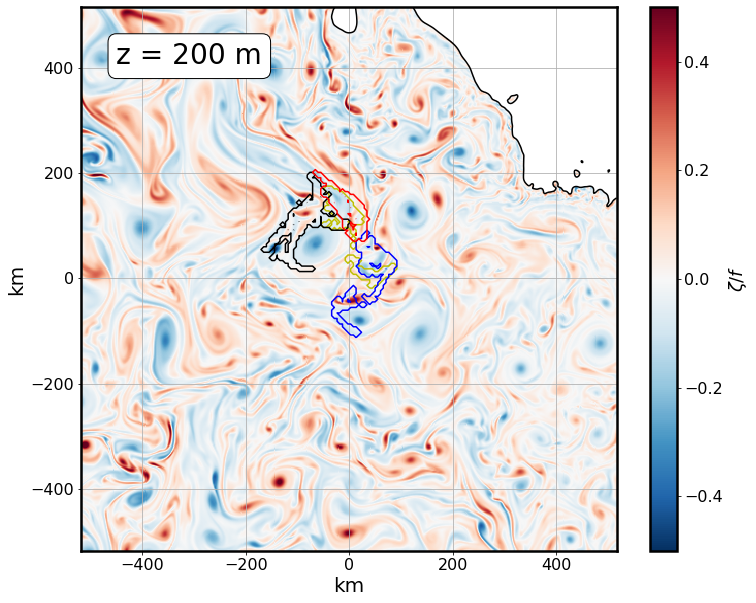

In [5]:
#folder = '/home2/datawork/tpicard/DATA_CNN/Pyticle_outputs/'
#file = folder + 'aperitif_simu2_trap1000m_sed50_2000dx_100nx_001900_002000_56_2000.nc'

folder = '/home2/datawork/tpicard/DATA_CNN/Pyticle_outputs/'
date_end = date_start + 100
#file = folder + 'apero_trap1000m_sed50_2000dx_100nx_{0:06}_{1:06}_56_{1:04}.nc'.format(date_start,date_end)
file = folder + 'aperitif_simu2_trap1000m_sed50_2000dx_100nx_{0:06}_{1:06}_56_{1:04}.nc'.format(date_start,date_end)


#List of the 36 sub-patches centers 
ic_all_list = np.linspace(1520.5,1610.5,6) #LONGITUDE
jc_all_list = np.linspace(569.5,659.5,6) #LAT
#Load data

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

nc_data = nc4.Dataset(file, 'r')
px = np.asfortranarray(nc_data.variables['px'])
py = np.asfortranarray(nc_data.variables['py'])
pdepth = np.asfortranarray(nc_data.variables['pdepth'])
nc_data.close()

plt.figure(figsize=(12,10))

plt.pcolormesh(lon,lat,vrt[:,:,1],cmap = plt.cm.RdBu_r,vmax=0.5,vmin=-0.5)
cb = plt.colorbar()
#plt.contour(lon,lat,topo,[1000],colors='k')
plt.contour(lon,lat,topo,[200],colors='k')
cb.set_label(r'$\zeta/f$',fontsize=18)
cb.ax.tick_params(labelsize=16)
#plt.scatter(px[0,0:10201],py[0,0:10201])
plt.xticks(size=16)
plt.yticks(size=16)
plt.ylabel('km',size=20)
plt.xlabel('km',size=20)
plt.grid()
level = [0.00001]
xband, yband = np.linspace(-260,260,100), np.linspace(-260,260,100)


plt.contour(xband,yband,jpdf[-1,14,0,:,:],colors='y',levels=level)
plt.contour(xband,yband,jpdf[-1,15,0,:,:],colors='k',levels=level)
plt.contour(xband,yband,jpdf[-1,20,0,:,:],colors='b',levels=level)
plt.contour(xband,yband,jpdf[-1,21,0,:,:],colors='r',levels=level)

props = dict(boxstyle='round', facecolor='white', alpha=1)
textstr = 'z = 200 m'
plt.text(-450, 450, textstr, fontsize=28,
        verticalalignment='top', bbox=props)

# PLOT FUSION

<ipython-input-7-5a0ca46be616>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lon,lat,vrt[:,:,3],cmap = plt.cm.RdBu_r,vmax=0.5,vmin=-0.5)
<ipython-input-7-5a0ca46be616>:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = plt.pcolormesh(lon,lat,vrt[:,:,1],cmap = plt.cm.RdBu_r,vmax=0.5,vmin=-0.5)


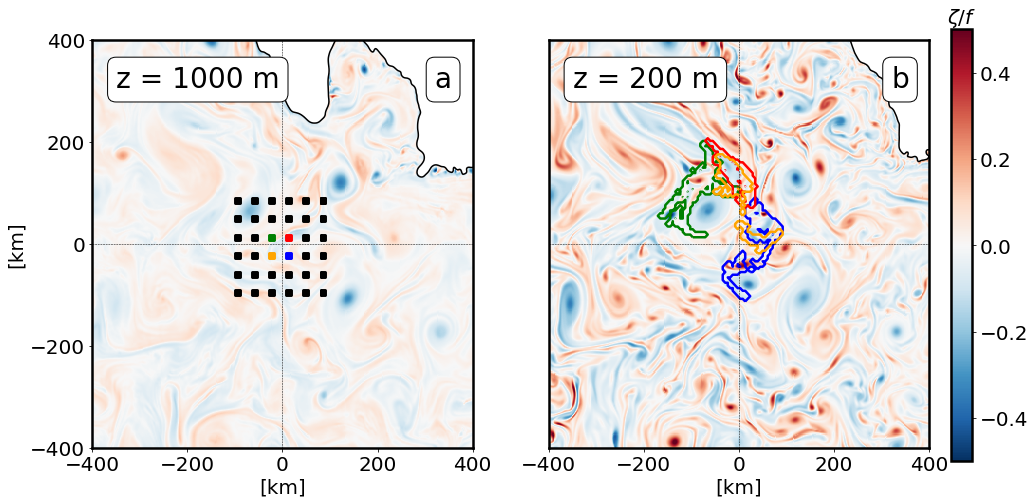

In [7]:
fig = plt.figure(figsize=(15,7.5))

fs = 20

ax = fig.add_subplot(1,2,1)
plt.pcolormesh(lon,lat,vrt[:,:,3],cmap = plt.cm.RdBu_r,vmax=0.5,vmin=-0.5)
#plt.pcolormesh(lon,lat,ssh[:,:],cmap = plt.cm.RdBu_r,vmax=0.5,vmin=-0.5)
#cb = plt.colorbar()
plt.contour(lon,lat,topo,[1000],colors='k')
cb.set_label(r'$\zeta/f$',fontsize=fs)
cb.ax.tick_params(labelsize=fs)
#plt.scatter(px[0,0:10201],py[0,0:10201])
plt.xticks(size=fs)
plt.yticks(size=fs)
plt.ylabel('[km]',size=fs)
plt.xlabel('[km]',size=fs)
#plt.grid()

counter = 0
for ic in ic_all_list[:]:
    for jc in jc_all_list:
        index = spatial_filter(px,py,ic,jc,0)
        px_km = (px[0,index]-ic_ori)*2
        py_km = (py[0,index]-jc_ori)*2
        #plt.scatter(px[0,index],py[0,index])

        if counter == 14:
            plt.scatter(px_km,py_km,s=3,color='orange')
        elif counter == 15:
            plt.scatter(px_km,py_km,s=3,color='g')
        elif counter == 20:
            plt.scatter(px_km,py_km,s=3,color='b')
        elif counter == 21:
            plt.scatter(px_km,py_km,s=3,color='r')
        else :
            plt.scatter(px_km,py_km,s=3,color='k')
        counter = counter +1
plt.scatter(px_km,py_km,s=3,color='k',label = 'Patch of particles')

props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
textstr = 'z = 1000 m'
plt.text(-350, 350, textstr, fontsize=28,
        verticalalignment='top', bbox=props)

textstr = 'a'
plt.text(320, 350, textstr, fontsize=28,
        verticalalignment='top', bbox=props)

plt.xlim(-400,400)
plt.ylim(-400,400)

plt.xticks([-400,-200,0,200,400],size=fs)
plt.yticks([-400,-200,0,200,400],size=fs)

plt.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
plt.axhline(y=0,color='black',linestyle='--',linewidth=0.5)

ax = fig.add_subplot(1,2,2)

pc = plt.pcolormesh(lon,lat,vrt[:,:,1],cmap = plt.cm.RdBu_r,vmax=0.5,vmin=-0.5)

plt.xlim(-400,400)
plt.ylim(-400,400)

#plt.contour(lon,lat,topo,[1000],colors='k')
plt.contour(lon,lat,topo,[200],colors='k')

#plt.scatter(px[0,0:10201],py[0,0:10201])
plt.xticks([-400,-200,0,200,400],size=fs)
plt.yticks([],size=fs)


#plt.ylabel('km',size=20)
plt.xlabel('[km]',size=20)
#plt.grid()
level = [0.00001]
level = [0.000001]
xband, yband = np.linspace(-260,260,100), np.linspace(-260,260,100)

index = 0

plt.contour(xband,yband,jpdf[-1,15,index,:,:],colors='g',levels=level,linewidths=2.5)
plt.contour(xband,yband,jpdf[-1,20,index,:,:],colors='b',levels=level,linewidths=2.5)
plt.contour(xband,yband,jpdf[-1,21,index,:,:],colors='r',levels=level,linewidths=2.5)
plt.contour(xband,yband,jpdf[-1,14,index,:,:],colors='orange',levels=level,linewidths=2.5)

props = dict(boxstyle='round', facecolor='white', alpha=1)
textstr = 'z = 200 m'
plt.text(-350, 350, textstr, fontsize=28,
        verticalalignment='top', bbox=props)
textstr = 'b'
plt.text(320, 350, textstr, fontsize=28,
        verticalalignment='top', bbox=props)

plt.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
plt.axhline(y=0,color='black',linestyle='--',linewidth=0.5)

#cbar_ax = fig.add_axes([0.495, 0.15, 0.02, 0.7])
cbar_ax = fig.add_axes([0.92, 0.10, 0.02, 0.8])
cb = plt.colorbar(pc,cax=cbar_ax)
cb.ax.set_title(r'$\zeta/f$',fontsize=fs)
cb.ax.tick_params(labelsize=fs)

#plt.savefig('particle_patches_decorrelation.png',dpi=400)
